# **Fraud Detection in Financial Transactions**  
In this notebook, we will work on a simulated **transactions** data for **fraud detection**. We will start with the analysis of fraud and create new features, then run machine learning models with **BigQuery ML** and **Vertex Tables** following a hybrid approach. We will evaluate the ML model on a test dataset and export the predictions to BigQuery to take actions. <br>
The public data used in the exercise is downloaded from the Kaggle website: <br>
https://www.kaggle.com/ealaxi/paysim1 <br> 

<br>**Import the required libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

##  **01. Download data** 

In [2]:
!pip install --quiet kaggle

In [3]:
!kaggle datasets download -d ealaxi/paysim1

 91%|████████████████████████████████████▏   | 161M/178M [00:02<00:00, 47.7MB/s]
100%|████████████████████████████████████████| 178M/178M [00:02<00:00, 76.0MB/s]


**NOTE:** If you get "kaggle.json file not found error", then download **the json file** first from kaggle homepage www.kaggle.com -> Your Account -> **Create New API token** and copy that file to your **[user-home]/.kaggle** folder (eg. /home/jupyter/.kaggle) and rerun. 

In [4]:
!unzip paysim1.zip 

Archive:  paysim1.zip
  inflating: PS_20174392719_1491204439457_log.csv  


##  **02. Load data** 

In [11]:
# check the project id.
PROJECT    = !gcloud config get-value project
PROJECT_ID = PROJECT[0]
print(PROJECT_ID)

bonibon


In [72]:
# create a bigquery dataset called "fraud_demo" using bq mk command in "europe-west4" region. 
!bq --location=europe-west4 mk --dataset fraud_demo

**There are different options available to load data from local to BigQuery table as seen below:** </br>
1. using bq command </br>
2. using BigQuery python client </br>
3. using BigQuery GUI


In [82]:
#option 1:
#load data using bq command.
!bq load --autodetect --source_format=CSV --max_bad_records=100000 fraud_demo.fraud ./PS_*.csv

Upload complete.
Waiting on bqjob_rb0fb7f24bc50949_0000017ac61767a2_1 ... (39s) Current status: DONE   


In [83]:
#option 2: 
# load data using bigquery python client.
from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client()

# table_id = "your-project.your_dataset.your_table_name"
table_id= "fraud_demo.fraud"
file_path = "./PS_20174392719_1491204439457_log.csv"

job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV, skip_leading_rows=1, autodetect=True
)

# [TODO] if you have not uploaded the data yet and want to use the python client, then uncomment the following:
#with open(file_path, "rb") as source_file:
#    job = client.load_table_from_file(source_file, table_id, job_config=job_config)
#job.result()  # Waits for the job to complete.

#table = client.get_table(table_id)  # Make an API request.
#print(
#    "Loaded {} rows and {} columns to {}".format(
#        table.num_rows, len(table.schema), table_id
#    )
#)

**Load bigquery extension for calling cell magic to run a query and also display the result as a DataFrame**

In [21]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


## **03. Explore Data** 


In [84]:
%%bigquery df --verbose 
SELECT * 
FROM
fraud_demo.fraud

Executing query with job ID: c52dd516-08ba-41a9-bfc2-2834edecb041
Query executing: 32.01s
Query complete after 32.62s


In [86]:
df.head().T

,0,1,2,3,4
step,249,249,250,250,250
type,DEBIT,DEBIT,DEBIT,DEBIT,DEBIT
amount,6749.24,9318.08,310.59,6557.76,4824.92
nameOrig,C819774090,C504446086,C707138092,C957045762,C475290461
oldbalanceOrg,81514.2,33,2741.78,0,0
newbalanceOrig,74764.9,0,2431.19,0,0
nameDest,C1907170490,C1273144281,C1612311113,C1177243230,C349814050
oldbalanceDest,441101,17256,133220,9231.8,293689
newbalanceDest,447850,26574.1,133531,15789.5,298514
isFraud,0,0,0,0,0


In [87]:
df.shape

(6362620, 11)

In [88]:
df["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [89]:
df["isFlaggedFraud"].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [90]:
%%bigquery 
SELECT isFraud, type , count(*) cnt FROM `fraud_demo.fraud` 
group by isFraud, type

,isFraud,type,cnt
0,0,DEBIT,41432
1,0,CASH_IN,1399284
2,0,PAYMENT,2151495
3,0,CASH_OUT,2233384
4,1,CASH_OUT,4116
5,0,TRANSFER,528812
6,1,TRANSFER,4097


**Fraud is only flagged for CASH_OUT and TRANSFER type transactions.** </br> We can filter out the other transaction types while creating the modeling dataset in the data preparation step coming next.

##  **04. Prepare data** 

**In this step, we are creating new features, standardising the existing variables, creating an ID and filtering out the redundant transactions.** 

In [130]:
%%bigquery --verbose 
create or replace table fraud_demo.fraud_data as
SELECT * EXCEPT (oldbalanceOrg, isFlaggedFraud), 
        oldbalanceOrg as oldbalanceOrig, # standardize the variable naming.
        row_number() over(partition by nameOrig order by step desc) as origCnt,
        row_number() over(partition by nameDest order by step desc) as destCnt,
        if(oldbalanceOrg = 0.0, 1, 0) as origzeroFlg,
        if(newbalanceDest = 0.0, 1, 0) as destzeroFlg,
        round((newbalanceDest-oldbalanceDest-amount)) as amountDiff,
        generate_uuid() as id,           # create a unique id for each transaction.
FROM
fraud_demo.fraud
where type in ("CASH_OUT","TRANSFER")
      and (isFraud = 1 or (RAND()< 10/100))  # select 10% of the non-fraud cases 

Executing query with job ID: 54aaabb0-7db0-442b-840e-bf5cce5b524b
Query executing: 16.30s
Query complete after 16.89s


""


**Create a test dataset by splitting the data as "Train" and "Test" and randomly selecting 20% of the observations for test.**

In [98]:
%%bigquery df_model --verbose 
select *,
    if(RAND()< 20/100, "Test", "Train") as part
from fraud_demo.fraud_data

Executing query with job ID: 2513506d-7af2-47db-a24c-52a8e1cd2abc
Query executing: 7.10s
Query complete after 7.56s


**Run correlation analysis to see the interactions between variables.**

In [134]:
# correlation analysis.
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.light_palette((250, 100, 50), input="husl", n_colors=50).as_hex())
table = df_model[df_model['part']=="Train"][['isFraud', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
           'origCnt', 'destCnt', 'origzeroFlg', 'destzeroFlg', 'amountDiff']].corr(method='pearson')
table.style.background_gradient(cmap=my_cmap, axis = 0)

,isFraud,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,origCnt,destCnt,origzeroFlg,destzeroFlg,amountDiff
isFraud,1.000000,0.206106,0.405933,0.088876,-0.045302,-0.026689,-0.001577,-0.043044,-0.157207,0.608083,-0.202635
amount,0.206106,1.000000,0.416351,0.153087,0.241787,0.427925,0.000054,-0.008308,-0.013165,0.119977,0.019248
oldbalanceOrig,0.405933,0.416351,1.000000,0.736656,-0.024971,0.008620,-0.000654,-0.017105,-0.123253,0.278953,-0.396038
newbalanceOrig,0.088876,0.153087,0.736656,1.000000,-0.010700,-0.012882,-0.000423,-0.002244,-0.055855,0.118066,-0.253585
oldbalanceDest,-0.045302,0.241787,-0.024971,-0.010700,1.000000,0.970541,0.002370,0.021453,0.140415,-0.053360,0.062163
newbalanceDest,-0.026689,0.427925,0.008620,-0.012882,0.970541,1.000000,0.002276,0.025169,0.130229,-0.059861,0.196510
origCnt,-0.001577,0.000054,-0.000654,-0.000423,0.002370,0.002276,1.000000,0.004735,0.003166,-0.001266,0.000749
destCnt,-0.043044,-0.008308,-0.017105,-0.002244,0.021453,0.025169,0.004735,1.000000,0.045083,-0.021720,0.053670
origzeroFlg,-0.157207,-0.013165,-0.123253,-0.055855,0.140415,0.130229,0.003166,0.045083,1.000000,-0.109764,0.035181
destzeroFlg,0.608083,0.119977,0.278953,0.118066,-0.053360,-0.059861,-0.001266,-0.021720,-0.109764,1.000000,-0.262933


**The variables "newbalanceDest" and "oldalanceDest" are highly correlated so we may keep only one of them as input in the supervised models. Since the correlation of "oldbalanceDest" and "isFraud" flag is higher, we decide to keep that variable.**

In [175]:
print("Train size", df_model[df_model['part']=="Train"].shape)
print("Test size ", df_model[df_model['part']=="Test"].shape)

Train size (227194, 17)
Test size  (56211, 17)


**Write the dataframes to BigQuery as train and test tables.**

In [111]:
# write dataframes to bigquery tables using BQ client.
df_model[df_model['part']=="Train"].to_gbq('fraud_demo.fraud_train', project_id= str(PROJECT_ID), if_exists='replace')
df_model[df_model['part']=="Test"].to_gbq('fraud_demo.fraud_test', project_id= str(PROJECT_ID), if_exists='replace')

1it [00:38, 38.43s/it]
1it [00:13, 13.49s/it]


## **05. Build an unsupervised model using k-means in BigQuery ML** 

#### See the parameters for kmeans model in BigQuery ML: </br> https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-kmeans#create_model_statement

In [153]:
%%bigquery --verbose
#create unsupervised model for fraud detection;
CREATE OR REPLACE MODEL
  fraud_demo.model_unsupervised OPTIONS(model_type='kmeans', kmeans_init_method = "kmeans++", num_clusters=7, standardize_features=true) AS 
    SELECT * EXCEPT (id, isFraud, nameOrig, nameDest, part)
    FROM
    `fraud_demo.fraud_train`;

select *
from ML.EVALUATE(MODEL `fraud_demo.model_unsupervised`);

Executing query with job ID: 274bad5f-5251-48a3-9913-641cee25dfdb
Query executing: 81.25s
Query complete after 81.66s


,davies_bouldin_index,mean_squared_distance
0,0.759019,6.141867


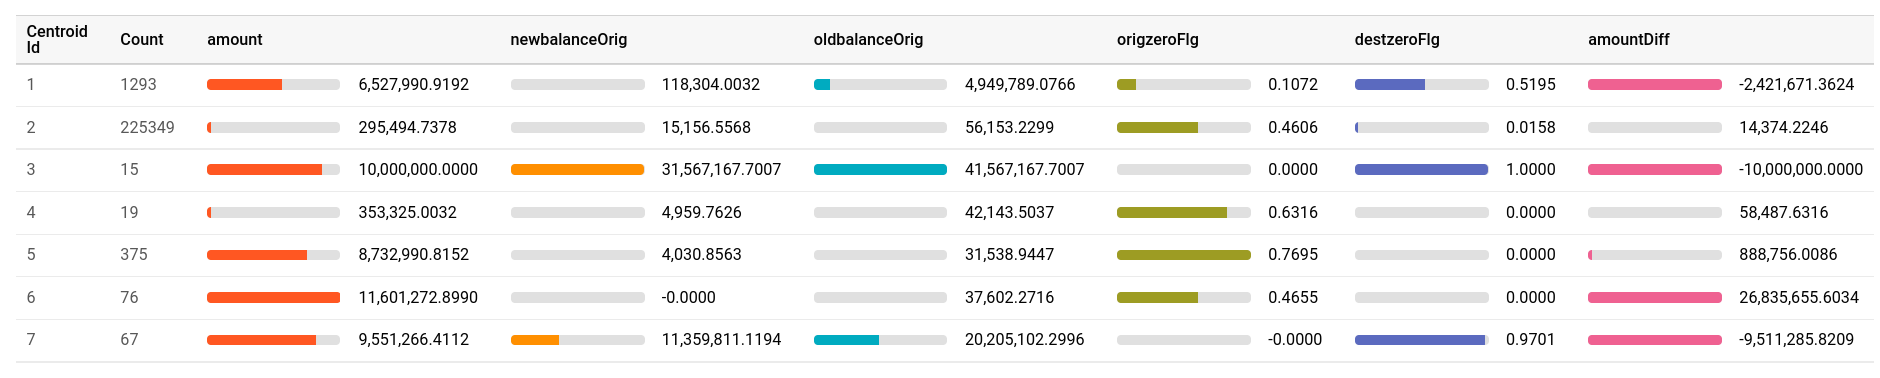

**Check the number of fraud flags within in cluster in the test data.**

In [201]:
%%bigquery --verbose
#test the model on a test data;
SELECT
  centroid_id, sum(isFraud) as sum,  count(*) cnt
FROM
  ML.PREDICT(MODEL `fraud_demo.model_unsupervised`,
    (
    SELECT *
    FROM  `fraud_demo.fraud_test`))
group by centroid_id
order by centroid_id;

Executing query with job ID: fe0650f8-a63b-4bd0-a5bc-46781291b8d0
Query executing: 26.35s
Query complete after 26.59s


,centroid_id,sum,cnt
0,1,258,296
1,2,1383,55781
2,3,6,7
3,4,0,6
4,5,0,89
5,6,0,25
6,7,7,7


**Detect anomalies within each cluster in BQML.** </br>
    https://cloud.google.com/blog/products/data-analytics/how-to-use-bigquery-ml-for-anomaly-detection

In [202]:
%%bigquery --verbose
#test the model on a test data;
SELECT
  centroid_id, sum(isfraud) as sum,  count(*) cnt
FROM
  ML.DETECT_ANOMALIES(MODEL `fraud_demo.model_unsupervised`, struct(0.2 as contamination),
    (
    SELECT *
    FROM  `fraud_demo.fraud_test`))
group by centroid_id
order by centroid_id

Executing query with job ID: 26df8223-2b63-4bc2-94fe-944c536d4702
Query executing: 4.81s
Query complete after 5.02s


,centroid_id,sum,cnt
0,1,1131,2655
1,2,465,49090
2,3,6,7
3,4,0,6
4,5,42,4410
5,6,0,33
6,7,10,10


**Centroid ID: 1, 3 and 7 are the segments that we would pay attention for fraudulent activities in the production data.**

##  **06. Build supervised model using BigQuery ML**  
https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create

In [147]:
%%bigquery --verbose
CREATE OR REPLACE MODEL `fraud_demo.model_fraud_reg`
 OPTIONS(MODEL_TYPE='LOGISTIC_REG', INPUT_LABEL_COLS = ["isFraud"], SUBSAMPLE=0.8) 
AS SELECT
  * EXCEPT (id, nameOrig, nameDest, part, step)
FROM `fraud_demo.fraud_train`

Executing query with job ID: 96cca1a6-0b42-480f-a338-b092f766408a
Query executing: 144.47s
Query complete after 145.23s


""


In [148]:
%%bigquery
SELECT * 
FROM ML.EVALUATE(MODEL fraud_demo.model_fraud_reg)

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.879581,0.57732,0.985522,0.697095,0.060833,0.950393


In [151]:
%%bigquery --verbose
CREATE OR REPLACE MODEL `fraud_demo.model_fraud_btree`
 OPTIONS(MODEL_TYPE='BOOSTED_TREE_CLASSIFIER',INPUT_LABEL_COLS = ["isFraud"], SUBSAMPLE=0.8) 
AS SELECT
  * EXCEPT (id, nameOrig, nameDest, part, step)
FROM `fraud_demo.fraud_train`

Executing query with job ID: 335fa7dc-ccdc-4ed6-ac90-d3521f34e435
Query executing: 427.82s
Query complete after 428.24s


""


In [150]:
%%bigquery
SELECT * 
FROM ML.EVALUATE(MODEL fraud_demo.model_fraud_btree)

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.973485,0.914591,0.996876,0.943119,0.011003,0.999975


**For now, skip this step and use Vertex Tables GUI to create an AutoML model on fraud_train data.**

In [180]:
#%%bigquery --verbose
#CREATE OR REPLACE MODEL `fraud_demo.model_fraud_automl`
#OPTIONS(MODEL_TYPE = 'AUTOML_CLASSIFIER' ,
#        BUDGET_HOURS = 1.0,
#        INPUT_LABEL_COLS = ["isFraud"])
#as select
#  * EXCEPT (id, nameOrig, nameDest, part, step)
#FROM `fraud_demo.fraud_train`

## **07. Batch prediction** 

In [209]:
%%bigquery fraud_supervised --verbose
# Predict the likelihood on new data.
SELECT id, isFraud, p.prob as score
FROM
  ML.PREDICT(MODEL `fraud_demo.model_fraud_btree`, 
  (SELECT * FROM
  `fraud_demo.fraud_test` 
  )
)
, unnest(predicted_isFraud_probs) as p
where p.label = 1
order by p.prob desc

Executing query with job ID: 80e3724a-129f-48e5-a41e-ad2e86cb699c
Query executing: 50.29s
Query complete after 50.74s


In [213]:
%%bigquery fraud_unsupervised --verbose
SELECT
  id, centroid_id, is_anomaly
FROM
  ML.DETECT_ANOMALIES(MODEL `fraud_demo.model_unsupervised`, struct(0.2 as contamination),
    (
    SELECT *
    FROM  `fraud_demo.fraud_test`))
where centroid_id in (1,3,7)

Executing query with job ID: 4f8077c9-452b-4bca-a1b9-42e169bfdfcf
Query executing: 27.51s
Query complete after 27.90s


## **08. Combining supervised and unsupervised model results for a hybrid decision** 

In [215]:
result_hybrid = fraud_supervised.merge(fraud_unsupervised, how='left', on='id')

In [216]:
result_hybrid

,id,isFraud,score,centroid_id,is_anomaly
0,2f284b85-b8a4-4187-95ad-ddb3fdd49970,1,0.997826,1.0,True
1,10233cf3-3728-4a17-a9f4-29dba08417f9,1,0.997826,1.0,True
2,1e30e837-b092-432b-ab5f-e004032ebbe4,1,0.997382,1.0,True
3,0fef7d54-ed41-4e54-8178-915af17eeebe,1,0.996899,1.0,True
4,1cf6a930-2d36-4b3f-ae3c-d5df5de1f211,1,0.996424,1.0,True
...,...,...,...,...,...
56206,62c3eaa2-5aba-4210-a41c-a30757ec3fe3,0,0.001028,NaN,NaN
56207,9ad3aebe-bdc0-4d79-8311-0bb731dc0f2e,0,0.001020,NaN,NaN
56208,919270ba-1fd1-44fe-a5b0-53f81b8bb725,0,0.001015,NaN,NaN
56209,af880822-6bf5-4128-89d9-2f301d25e45e,0,0.001014,NaN,NaN


In [217]:
result_hybrid["isFraud"].value_counts()

0    54557
1     1654
Name: isFraud, dtype: int64

**The overall fraud rate in the test data is less than %0.03**

In [254]:
result_hybrid[result_hybrid.score >.4]['isFraud'].value_counts()

1    1490
0      81
Name: isFraud, dtype: int64

**Almost 95% of the transactions selected based on the high probability score are flagged as fraud in the actual target.**

In [237]:
result_hybrid[result_hybrid.centroid_id == 1.0]['isFraud'].value_counts()

0    1524
1    1131
Name: isFraud, dtype: int64

In [238]:
result_hybrid[result_hybrid.centroid_id == 3.0]['isFraud'].value_counts()

1    6
0    1
Name: isFraud, dtype: int64

In [239]:
result_hybrid[result_hybrid.centroid_id == 7.0]['isFraud'].value_counts()

1    10
Name: isFraud, dtype: int64

**Tracking "false negatives" : Check the transactions that have low prediction score in supervised model but classified in outlier segments in unsupervised model.**

In [256]:
result_hybrid[result_hybrid.centroid_id == 1.0][result_hybrid.score < 0.4][result_hybrid.score > 0.3]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,id,isFraud,score,centroid_id,is_anomaly
1591,2d91db9c-2d29-4dfd-98ec-ba440aec14f4,1,0.388154,1.0,True
1596,4b61fdf4-7f3b-4b8f-bcb0-12adb518ab63,1,0.383449,1.0,True
1601,99a260f5-c629-459b-a011-abb3d7e0796b,1,0.379993,1.0,True
1614,16696b68-28a4-4cd0-b972-9ac5dfa319b4,0,0.372311,1.0,True
1622,f2424f1c-b910-4f3c-87f1-be44bb64bad9,1,0.367952,1.0,True
1623,63419da7-2031-4efc-b1f8-ba3f686dcb9e,0,0.364341,1.0,True
1626,3e444f82-18b1-4123-970c-a7c510772218,1,0.363813,1.0,True
1639,600a617d-4e14-4eb0-bbb8-185e0695d829,1,0.356012,1.0,True
1646,666d38e6-c895-4bfa-bc99-88c62ab5a7f3,1,0.353354,1.0,True
1662,1c13c023-557d-4644-a665-a897750a9bb7,1,0.344492,1.0,True


In [240]:
result_hybrid.to_gbq('fraud_demo.result_hybrid', project_id= str(PROJECT_ID), if_exists='replace')

1it [00:07,  7.53s/it]


<font color='green'> **End of file.** </font>